<a href="https://colab.research.google.com/github/RainiBenaiah/Time-Series-Forecasting/blob/main/Air_Quality_Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [172]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [173]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [174]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


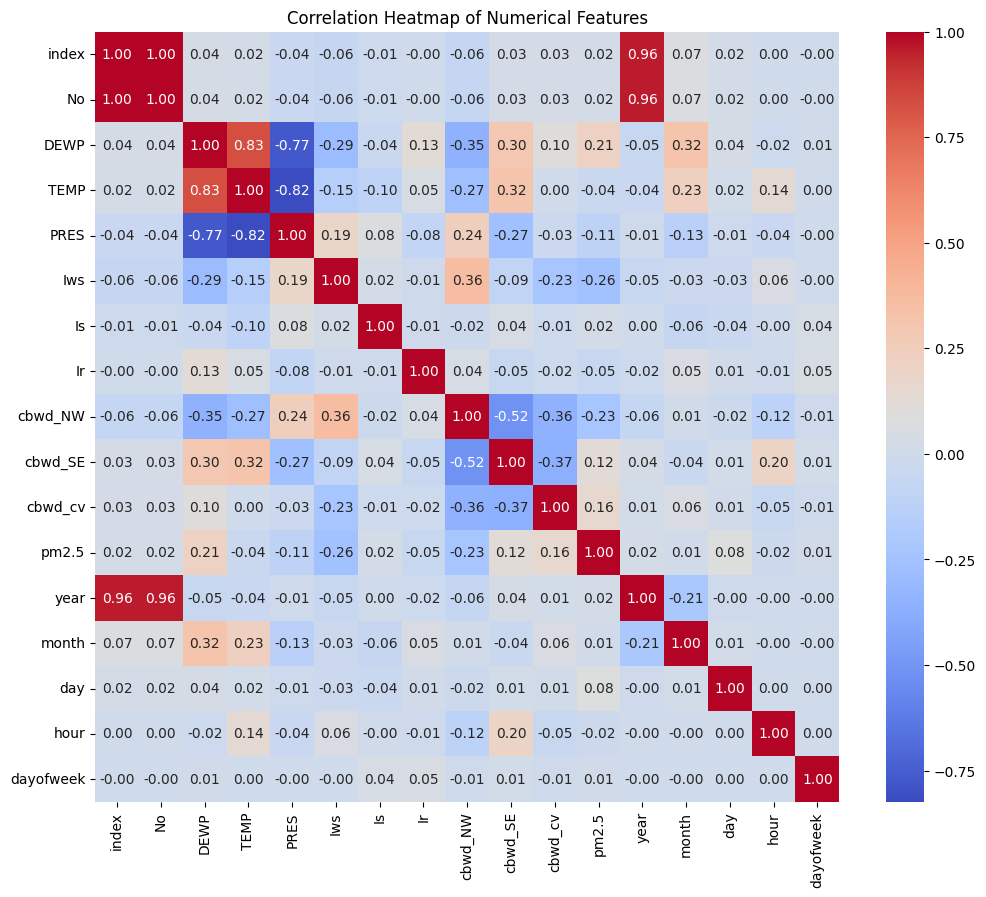

In [208]:
# prompt: create a heatmap

import seaborn as sns

# Select numerical columns for correlation analysis
numerical_cols = train.select_dtypes(include=np.number).columns

# Calculate the correlation matrix
correlation_matrix = train[numerical_cols].corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [175]:
train.shape

(30676, 12)

In [176]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

**Handle Missing Values**


*   Check the dataset and decide how to handle them



In [177]:
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
datetime,0
cbwd_NW,0
cbwd_SE,0


In [178]:
test.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
datetime,0
cbwd_NW,0
cbwd_SE,0


In [179]:
train['pm2.5'] = train['pm2.5'].interpolate(method='linear')


In [180]:
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
datetime,0
cbwd_NW,0
cbwd_SE,0


In [181]:
# Backward fill first, then add controlled noise
train['pm2.5'] = train['pm2.5'].fillna(method='bfill')

# Add random variation to the first 24 values
first_valid_value = train['pm2.5'].iloc[24]  # The value that was back-filled
noise_std = train['pm2.5'].std() * 0.1  # 10% of overall standard deviation

# Replace the flat values with varied ones
np.random.seed(42)  # For reproducibility
train.loc[:23, 'pm2.5'] = first_valid_value + np.random.normal(0, noise_std, 24)

# Ensure no negative values if pm2.5 can't be negative
train.loc[:23, 'pm2.5'] = np.maximum(train.loc[:23, 'pm2.5'], 0)

<ipython-input-181-e8d216824943>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['pm2.5'] = train['pm2.5'].fillna(method='bfill')


In [182]:
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
datetime,0
cbwd_NW,0
cbwd_SE,0


In [183]:
train.head(25)

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,133.543378
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,127.735315
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,134.924321
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,142.930951
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,126.858230
5,6,-1.442309,-1.840273,0.053790,-0.155751,-0.069353,-0.137667,2010-01-01 05:00:00,1.448138,-0.732019,-0.522096,126.858380
6,7,-1.442309,-1.758296,0.053790,-0.093164,-0.069353,-0.137667,2010-01-01 06:00:00,1.448138,-0.732019,-0.522096,143.444849
7,8,-1.442309,-1.758296,0.053790,-0.057371,-0.069353,-0.137667,2010-01-01 07:00:00,1.448138,-0.732019,-0.522096,136.019623
8,9,-1.442309,-1.758296,0.053790,0.005216,-0.069353,-0.137667,2010-01-01 08:00:00,1.448138,-0.732019,-0.522096,124.705780
9,10,-1.511594,-1.676318,0.053790,0.067804,-0.069353,-0.137667,2010-01-01 09:00:00,1.448138,-0.732019,-0.522096,133.962724


# Datetime Feature Engineering


In [184]:
train = train.reset_index()
test = test.reset_index()


In [185]:
train.columns

Index(['index', 'No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime',
       'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [186]:
test.columns

Index(['index', 'No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime',
       'cbwd_NW', 'cbwd_SE', 'cbwd_cv'],
      dtype='object')

In [187]:
train['datetime'].head(10)


,datetime
0,2010-01-01 00:00:00
1,2010-01-01 01:00:00
2,2010-01-01 02:00:00
3,2010-01-01 03:00:00
4,2010-01-01 04:00:00
5,2010-01-01 05:00:00
6,2010-01-01 06:00:00
7,2010-01-01 07:00:00
8,2010-01-01 08:00:00
9,2010-01-01 09:00:00


In [188]:
train['datetime'].isnull().sum()

np.int64(0)

In [189]:
# Ensure datetime is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

# Extract useful features
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek  # Monday = 0


In [ ]:
train.drop(columns=['datetime'])


,index,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,year,month,day,hour,dayofweek
0,0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,133.543378,2010,1,1,0,4
1,1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,127.735315,2010,1,1,1,4
2,2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,134.924321,2010,1,1,2,4
3,3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,142.930951,2010,1,1,3,4
4,4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,126.858230,2010,1,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30671,30671,30672,1.467633,0.946961,-2.088668,-0.415099,-0.069353,2.687490,-0.690542,-0.732019,-0.522096,50.000000,2013,7,1,23,0
30672,30672,30673,1.329064,0.864984,-2.186052,-0.379306,-0.069353,3.393779,1.448138,-0.732019,-0.522096,41.000000,2013,7,2,0,1
30673,30673,30674,1.259780,0.701029,-2.088668,-0.263130,-0.069353,4.100068,1.448138,-0.732019,-0.522096,32.000000,2013,7,2,1,1
30674,30674,30675,1.190496,0.701029,-2.088668,-0.146953,-0.069353,4.806358,1.448138,-0.732019,-0.522096,19.000000,2013,7,2,2,1


**Separate Features and Target**

In [199]:
X_train = train.drop(['pm2.5', 'No', 'index', 'datetime'], axis=1)
y_train = train['pm2.5']

In [200]:
X_train.shape



(30676, 14)

In [201]:
y_train.shape

(30676,)

In [202]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scaling
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(X_train)
y_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Sequence length (timesteps)
sequence_length = 72

X_seq = []
y_seq = []

for i in range(sequence_length, len(X_scaled)):
    X_seq.append(X_scaled[i-sequence_length:i])  # past 72 hours
    y_seq.append(y_scaled[i])                    # target is current hour's PM2.5

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("X_seq shape:", X_seq.shape)  # should be (samples, 72, 14)
print("y_seq shape:", y_seq.shape)  # should be (samples, 1)


X_seq shape: (30604, 72, 14)
y_seq shape: (30604, 1)


In [195]:

X_train = np.expand_dims(X_train, axis=1)

In [203]:
# Assume X_seq and y_seq are your full sequences from preprocessing
split_index = int(len(X_seq) * 0.8)

X_train, X_val = X_seq[:split_index], X_seq[split_index:]
y_train, y_val = y_seq[:split_index], y_seq[split_index:]


In [204]:
print("X_train shape:", X_train.shape)  # Should be (samples, 72, 14)
print("y_train shape:", y_train.shape)

X_train shape: (24483, 72, 14)
y_train shape: (24483, 1)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [205]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import GRU
# Build model
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # No activation = linear output

# Compile
model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='mean_squared_error',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train,
    epochs=100,               # Can increase to 100
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    shuffle=False
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 32s 39ms/step - lambda: 0.1637 - loss: 0.0457 - val_lambda: 0.0813 - val_loss: 0.0114
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - lambda: 0.0679 - loss: 0.0067 - val_lambda: 0.0791 - val_loss: 0.0117
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - lambda: 0.0632 - loss: 0.0060 - val_lambda: 0.0798 - val_loss: 0.0125
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - lambda: 0.0618 - loss: 0.0059 - val_lambda: 0.0808 - val_loss: 0.0130
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - lambda: 0.0612 - loss: 0.0059 - val_lambda: 0.0816 - val_loss: 0.0133
Epoch 6/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - lambda: 0.0609 - loss: 0.0058 - val_lambda: 0.0821 - val_loss: 0.0134


In [206]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,869 (237.77 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,580 (158.52 KB)

957/957 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step


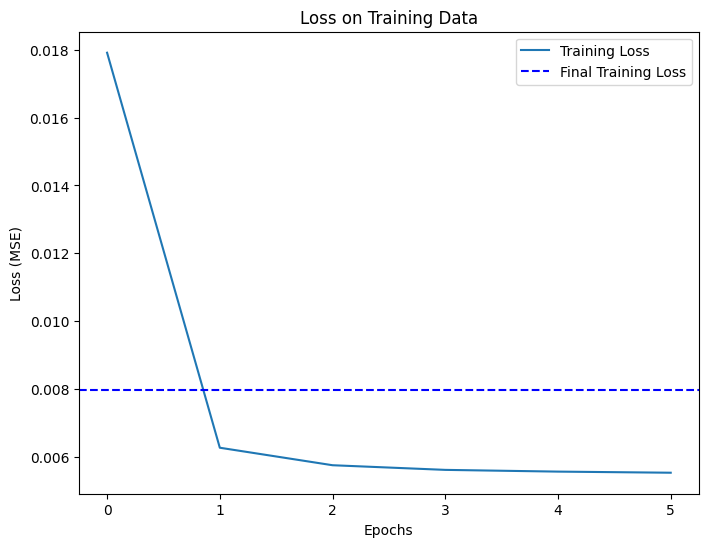

Final Training Loss (MSE): 0.007971773235013035


In [207]:
# Calculate training loss
# Use X_seq which has the correct shape (samples, timesteps, features) for prediction
train_predictions = model.predict(X_seq)
# The target y_seq was used for training, use it for calculating the loss
train_loss = np.mean((y_seq - train_predictions)**2) # y_seq is already the target for X_seq

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
# Use the calculated train_loss (MSE on the sequenced data)
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Training Loss')  # Final training loss on sequenced data
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [ ]:
# Handle datetime
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek

In [ ]:
test.head()

,index,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,year,month,day,hour,dayofweek
0,0,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,2013-07-02 04:00:00,1.448138,-0.732019,-0.522096,2013,7,2,4,1
1,1,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,2013-07-02 05:00:00,1.448138,-0.732019,-0.522096,2013,7,2,5,1
2,2,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,2013-07-02 06:00:00,1.448138,-0.732019,-0.522096,2013,7,2,6,1
3,3,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,2013-07-02 07:00:00,1.448138,-0.732019,-0.522096,2013,7,2,7,1
4,4,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,2013-07-02 08:00:00,1.448138,-0.732019,-0.522096,2013,7,2,8,1


In [ ]:
# Drop unnecessary columns
test_X = test.drop(['No', 'index', 'datetime'], axis=1)


In [ ]:

# Scale features
test_scaled = feature_scaler.transform(test_X)

In [ ]:
test_seq = []

for i in range(sequence_length, len(test_scaled)):
    test_seq.append(test_scaled[i-sequence_length:i])

test_seq = np.array(test_seq)
print(test_seq.shape)


(13124, 24, 14)


In [ ]:
test.shape

(13148, 17)

In [ ]:
from scipy import stats

pred_scaled = model.predict(test_seq)
pred_pm25 = target_scaler.inverse_transform(pred_scaled)

x = np.arange(5)
y = pred_pm25[:5].flatten()
slope, intercept, _, _, _ = stats.linregress(x, y)

#extrapolate
extrapolated = (intercept - slope * np.arange(24, 0, -1))

# combine
from scipy import stats

pred_scaled = model.predict(test_seq)
pred_pm25 = target_scaler.inverse_transform(pred_scaled)

x = np.arange(5)
y = pred_pm25[:5].flatten()
slope, intercept, _, _, _ = stats.linregress(x, y)

#extrapolate
extrapolated = (intercept - slope * np.arange(24, 0, -1))

# combine
combined = np.concatenate((extrapolated, pred_pm25.flatten()))

timestamps = test.datetime

assert len(combined) == len(timestamps),  f"Expected {len(timestamps)}, got {len(combined)}"

#create submission
submission = pd.DataFrame({
    'row ID': timestamps,
    'pm2.5': combined
})

# date format
submission['row ID'] = pd.to_datetime(submission['row ID']).apply(
    lambda x : f"{x.year}-{x.month:02d}-{x.day:02d} {x.hour}:{x.minute:02d}:{x.second:02d}"
)

# save
submission.to_csv('submission.csv', index=False)
print(f'Saved {submission.shape[0]} rows to submission.csv')

#create submission
submission = pd.DataFrame({
    'row ID': timestamps,
    'pm2.5': combined
})

# date format
submission['row ID'] = pd.to_datetime(submission['row ID']).apply(
    lambda x : f"{x.year}-{x.month:02d}-{x.day:02d} {x.hour}:{x.minute:02d}:{x.second:02d}"
)

# save
submission.to_csv('submission.csv', index=False)
print(f'Saved {submission.shape[0]} rows to submission.csv')


411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Saved 13148 rows to submission.csv
Saved 13148 rows to submission.csv


In [ ]:
submission.head(27)

,row ID,pm2.5
0,2013-07-02 4:00:00,183.628275
1,2013-07-02 5:00:00,178.840752
2,2013-07-02 6:00:00,174.053229
3,2013-07-02 7:00:00,169.265706
4,2013-07-02 8:00:00,164.478183
5,2013-07-02 9:00:00,159.690660
6,2013-07-02 10:00:00,154.903137
7,2013-07-02 11:00:00,150.115614
8,2013-07-02 12:00:00,145.328091
9,2013-07-02 13:00:00,140.540569


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/sample_submission .csv')
submission.head()


,row ID,pm2.5
0,2013-07-02 4:00:00,14
1,2013-07-02 5:00:00,14
2,2013-07-02 6:00:00,14
3,2013-07-02 7:00:00,14
4,2013-07-02 8:00:00,14
